In [1]:
import os
import sys
sys.path.append("../")

import glob
import warnings
import collections
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import display
from PIL import Image

from datasets.wafer import WM811K_LABELS
from datasets.wafer import LabeledWM811kFolder, get_dataloader
from datasets.transforms import BasicTransform, RotationTransform
from models.config import RESNET_BACKBONE_CONFIGS
from models.resnet.backbone import ResNetBackbone
from models.head import GAPClassifier

In [2]:
from captum.attr import GuidedGradCam, LayerGradCam

# Load classification model from checkpoint

In [3]:
cfg = dict(
    backbone_type='resnet',
    backbone_config='18.original',
    in_channels=2,
    projector_type='linear',
    projector_size=128,
    num_negatives=5000,
    noise=0.05,
    rotate=True,   
)

In [4]:
backbone = ResNetBackbone(
    layer_config=RESNET_BACKBONE_CONFIGS[cfg['backbone_config']],
    in_channels=cfg['in_channels']
)
print(backbone)

ResNetBackbone(
  (layers): Sequential(
    (block0): Sequential(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): Bat

In [5]:
head = GAPClassifier(
    in_channels=backbone.out_channels,
    num_classes=len(WM811K_LABELS),
    dropout=0.5
)
print(head)

GAPClassifier(
  (layers): Sequential(
    (gap): AdaptiveAvgPool2d(output_size=1)
    (flatten): Flatten()
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=512, out_features=9, bias=True)
  )
)


In [6]:
DI = 9
LP = 1.000

In [7]:
model_file = os.path.join(
    "../checkpoints/classification_pirl",
    f"{cfg['backbone_type']}.{cfg['backbone_config']}",
    f"{cfg['num_negatives']}.{cfg['projector_type']}.best.noise_{cfg['noise']:.2f}_rotate",
    f"DI_{DI:02}",
    f"LP_{LP:.3f}",
    "**/best_model.pt"
)

model_file = glob.glob(model_file, recursive=True)[0]
assert os.path.exists(model_file), model_file

In [8]:
backbone.load_weights_from_checkpoint(model_file, key='backbone')

In [9]:
head.load_weights_from_checkpoint(model_file, key='classifier')

# Load data

In [10]:
transforms = BasicTransform.get(size=(112, 112))
print(transforms)

Compose(
    Resize(size=(112, 112), interpolation=PIL.Image.NEAREST)
    ToTensor()
    Lambda()
)


In [11]:
train_set = LabeledWM811kFolder("../data/images/labeled/train/", transform=transforms)
valid_set = LabeledWM811kFolder("../data/images/labeled/valid/", transform=transforms)
test_set = LabeledWM811kFolder("../data/images/labeled/test/", transform=transforms)

In [12]:
print(f"Train : Validation : Test = {len(train_set):,} : {len(valid_set):,} : {len(test_set):,}")

Train : Validation : Test = 138,360 : 17,295 : 17,295


# Make predictions

In [25]:
net = nn.Sequential(
    collections.OrderedDict(
        [
            ('backbone', backbone),
            ('classifier', head),
        ]
    )
)

In [26]:
def predict_logits(dataset: torch.utils.data.Dataset, model: nn.Module, device: str, **kwargs):
    
    data_loader = get_dataloader(
        dataset,
        batch_size=kwargs.get('batch_size', 256),
        shuffle=False,
        num_workers=kwargs.get('num_workers', 0)
    )
    
    assert isinstance(model, nn.Module)
    model.eval()
    
    logits = torch.empty(len(dataset), head.num_classes)
    targets = torch.empty(len(dataset), dtype=torch.long)
    
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            
            x, m = batch['x'].to(device), batch['m'].to(device)
            
            if backbone.in_channels == 2:
                model_input = torch.cat([x, m], dim=1)
            else:
                model_input = x
            
            lgt = model(model_input)
            logits[batch['idx']] = lgt.cpu()
            targets[batch['idx']] = batch['y'].cpu()
            
    return logits, targets

In [27]:
DEVICE = 'cuda:2'

In [30]:
eval_configs = dict(model=net, device=DEVICE)

In [31]:
%%time
train_logits, train_targets = predict_logits(train_set, **eval_configs)

CPU times: user 9min 9s, sys: 12.3 s, total: 9min 21s
Wall time: 1min 39s


In [32]:
%%time
test_logits, test_targets = predict_logits(test_set, **eval_configs)

CPU times: user 1min 7s, sys: 1.43 s, total: 1min 8s
Wall time: 12.1 s


In [18]:
def get_max_proba(logits: torch.Tensor, return_index=True):
    assert logits.ndim == 2
    preds = nn.functional.softmax(logits)
    preds, indices = preds.max(dim=1)
    if return_index:
        return preds, indices
    else:
        return preds

In [19]:
%%time
train_preds, train_preds_indices = get_max_proba(train_logits)

CPU times: user 91.5 ms, sys: 1.65 ms, total: 93.2 ms
Wall time: 5.29 ms


In [20]:
%%time
test_preds, test_preds_indices = get_max_proba(test_logits)

CPU times: user 1.86 ms, sys: 60 µs, total: 1.92 ms
Wall time: 861 µs


In [144]:
def visualize_gradcam(net: nn.Module,
                      layer: nn.Module,
                      dataset: torch.utils.data.Dataset,
                      index: int or list,
                      in_channels: int = 2, **kwargs):
    
    if isinstance(index, int):
        index = [index]
    else:
        assert isinstance(index, list)
    
    device = kwargs.get('device', 'cpu')
    net, layer = net.to(device), layer.to(device)
    gradcam = LayerGradCam(net, layer)
    
    def create_gradcam_data(sample: dict, in_channels: int):
        x, m = sample.get('x').unsqueeze(0), sample.get('m').unsqueeze(0)
        target = sample.get('y')
        if in_channels == 2:
            out = torch.cat([x, m], dim=1)
        else:
            out = x
        
        assert out.ndim == 4, "(1, C, H, W)"
        return out, target
    
    def normalize_attribution(attrb: np.ndarray):
        assert len(attrb.shape) == 2
        v_min, v_max = attrb.min(), attrb.max()
        return (attrb - v_min) / (v_max - v_min)
        
    
    inputs, heatmaps, results = [], [], []
    for idx in index:
        
        # Get GradCam input
        input_, target_ = create_gradcam_data(dataset[idx], in_channels)
        assert input_.ndim == 4
        
        # Compute attribution
        attr = gradcam.attribute(input_.to(device), target_)
        
        from captum.attr import LayerAttribution
        upsample_size = tuple(input_.size()[2:])
        interpolate_configs = dict(
            interpolate_dims=upsample_size,
            interpolate_mode='bilinear',
        )
        upsampled_attr = LayerAttribution.interpolate(attr, **interpolate_configs)
        upsampled_attr = upsampled_attr.detach().cpu()
        assert (upsampled_attr.ndim == 4) & (upsampled_attr.squeeze().ndim == 2)
        
        saliency_map = normalize_attribution(upsampled_attr.squeeze().numpy())
        
        import cv2
        heatmap = (255 * saliency_map).astype(np.uint8)         # (H, W)    ~ [0, 255]
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # (H, W, 3) ~ [0, 255]
        heatmap = torch.from_numpy(heatmap).float().div(255)    # (H, W, 3) ~ [0, 1]
        b, g, r = heatmap.split(1, dim=-1)                      # 
        heatmap = torch.cat([r, g, b], dim=-1)                  # (H, W, 3) ~ [0, 1]
        
        input3d = input_.squeeze(0).permute(1, 2, 0).mean(dim=-1, keepdim=True) 
        result  = heatmap + input3d
        result  = result.div(result.max())                      # (H, W, 3)
        
        inputs   += [input3d.numpy()]
        heatmaps += [heatmap.numpy()]
        results  += [result.numpy()]
        
    return inputs, heatmaps, results

In [244]:
inputs, heatmaps, results = visualize_gradcam(
    net=net, layer=net.backbone.layers.block8.conv2,
    dataset=test_set,
    index=1,
    device='cuda:2',
)

(112, 112, 1)


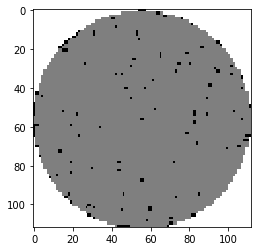

In [245]:
print(inputs[0].shape)
plt.imshow(inputs[0].squeeze(-1), cmap=plt.cm.binary)

(112, 112, 3)


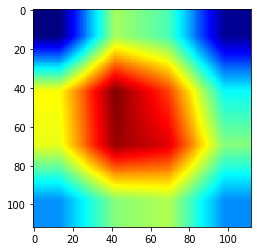

In [246]:
print(heatmaps[0].shape)
plt.imshow(heatmaps[0])

(112, 112, 3)


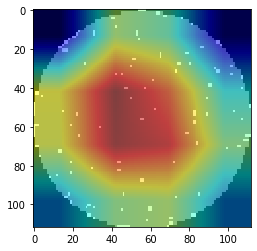

In [247]:
print(results[0].shape)
plt.imshow(results[0])

In [275]:
def visualize_guided_gradcam(net: nn.Module,
                      layer: nn.Module,
                      dataset: torch.utils.data.Dataset,
                      index: int or list,
                      in_channels: int = 2, **kwargs):
    
    if isinstance(index, int):
        index = [index]
    else:
        assert isinstance(index, list)
    
    device = kwargs.get('device', 'cpu')
    net, layer = net.to(device), layer.to(device)
    guided_gradcam = GuidedGradCam(net, layer)
    
    def create_gradcam_data(sample: dict, in_channels: int):
        x, m = sample.get('x').unsqueeze(0), sample.get('m').unsqueeze(0)
        target = sample.get('y')
        if in_channels == 2:
            out = torch.cat([x, m], dim=1)
        else:
            out = x
        
        assert out.ndim == 4, "(1, C, H, W)"
        return out, target
    
    def normalize_attribution(attr: np.ndarray):
        assert len(attr.shape) == 2
        v_min, v_max = attr.min(), attr.max()
        return (attr - v_min) / (v_max - v_min)
        
    inputs, heatmaps, results = [], [], []
    for idx in index:
        
        # Get GradCam input
        input_, target_ = create_gradcam_data(dataset[idx], in_channels)
        assert input_.ndim == 4
        
        # Compute attribution
        attr = guided_gradcam.attribute(
            input_.to(device), target_,
            interpolate_mode='nearest',
        )
        attr = attr.mean(dim=1, keepdim=True).detach().cpu()
        assert (attr.ndim == 4) & (attr.squeeze().ndim == 2)
        
        saliency_map = normalize_attribution(attr.squeeze().numpy())
        
        import cv2
        heatmap = (255 * saliency_map).astype(np.uint8)         # (H, W)    ~ [0, 255]
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # (H, W, 3) ~ [0, 255]
        heatmap = torch.from_numpy(heatmap).float().div(255)    # (H, W, 3) ~ [0, 1]
        b, g, r = heatmap.split(1, dim=-1)                      # 
        heatmap = torch.cat([r, g, b], dim=-1)                  # (H, W, 3) ~ [0, 1]
        
        input3d = input_.squeeze(0).permute(1, 2, 0).mean(dim=-1, keepdim=True) 
        result  = heatmap * 1.5 + input3d
        result  = result.div(result.max())                      # (H, W, 3)
        
        inputs   += [input3d.numpy()]
        heatmaps += [heatmap.numpy()]
        results  += [result.numpy()]
        
    return inputs, heatmaps, results

In [284]:
inputs, heatmaps, results = visualize_guided_gradcam(
    net=net, layer=net.classifier.layers.gap,
    dataset=test_set,
    index=9340,
    device='cuda:2',
)

(112, 112, 1)


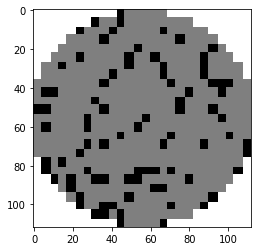

In [285]:
print(inputs[0].shape)
plt.imshow(inputs[0].squeeze(-1), cmap=plt.cm.binary)

(112, 112, 3)


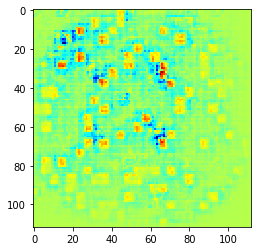

In [286]:
print(heatmaps[0].shape)
plt.imshow(heatmaps[0])

(112, 112, 3)


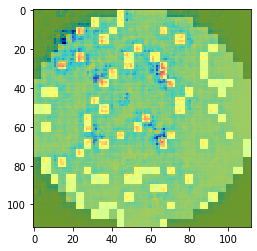

In [287]:
print(results[0].shape)
plt.imshow(results[0])